MovieWriter imagemagick unavailable; using Pillow instead.


## Optimize: Rosenbrock Function
iter# 0: Fitness:1.28726, Position:[ 0.00895464 -0.05515447], Velocity:4.249143197573187
iter# 1: Fitness:0.00526, Position:[1.06143385 1.12279232], Velocity:10.0
iter# 2: Fitness:0.00526, Position:[1.06143385 1.12279232], Velocity:10.0
iter# 3: Fitness:0.00526, Position:[1.06143385 1.12279232], Velocity:6.7899951234709235
iter# 4: Fitness:0.00526, Position:[1.06143385 1.12279232], Velocity:3.230618995058022
iter# 5: Fitness:0.00526, Position:[1.06143385 1.12279232], Velocity:2.3240394244393663
iter# 6: Fitness:0.00526, Position:[1.06143385 1.12279232], Velocity:1.3441241554449894
iter# 7: Fitness:0.00339, Position:[1.05587056 1.11649044], Velocity:0.7485230947050513
iter# 8: Fitness:0.00124, Position:[1.03342379 1.06685522], Velocity:0.5183873346991543
iter# 9: Fitness:0.00045, Position:[1.01898828 1.03737025], Velocity:0.48039025916476974
iter# 10: Fitness:0.00025, Position:[1.01177052 1.02262777], Velocity:0.4913885532901609
iter# 11: Fitness:0.00020

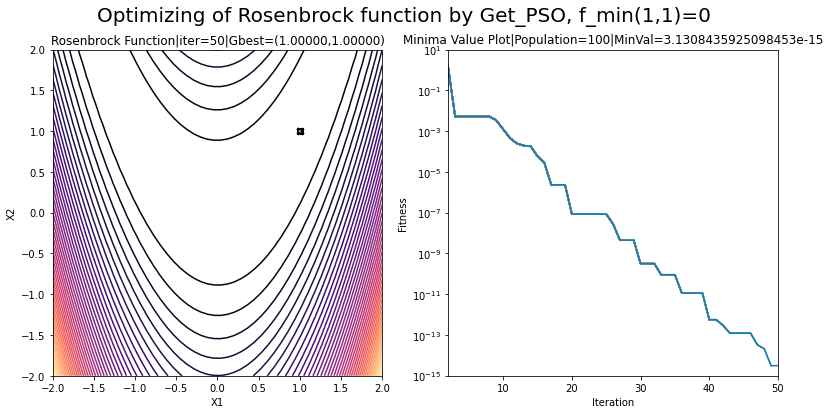

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import os

def Get_Rosenbrock_Function(x):
    return 100*(x[1] - x[0]**2)**2 + (x[0]-1)**2


def Get_PSO(func, bounds, nr_Size=10, nr_Inertia=0.5, pa=0.8, ga=0.9, 
        nr_Max_Velocity=10, nr_Iters=100, b_Verbose=False, nm_Function=None):

    bounds = np.array(bounds)
    assert np.all(bounds[:,0] < bounds[:,1]) 
    dim = len(bounds)
    X = np.random.rand(nr_Size, dim)
    print('## Optimize:',nm_Function)

    def clip_by_norm(x, max_norm):
        norm = np.linalg.norm(x)
        return x if norm <=max_norm else x * max_norm / norm

    particles = X * (bounds[:,1]-bounds[:,0]) + bounds[:,0]
    velocities = X * (bounds[:,1]-bounds[:,0]) + bounds[:,0]
    personal_bests = np.copy(particles)
    personal_best_fitness = [np.inf for p in particles]

    global_best_idx = np.argmin(personal_best_fitness)
    global_best = personal_bests[global_best_idx]
    global_best_fitness = func(global_best)
    history = {'particles':[], 
               'global_best_fitness':[], 
               'global_best':[[np.inf, np.inf] for i in range(nr_Iters)],
               'obj_func': nm_Function,}


    for i in range(nr_Iters):
        history['particles'].append(particles)
        history['global_best_fitness'].append(global_best_fitness)

        history['global_best'][i][0] = global_best[0]
        history['global_best'][i][1] = global_best[1]

        if b_Verbose: print('iter# {}:'.format(i), end='')

        for p_i in range(nr_Size):
            fitness = func(particles[p_i])
            if fitness < personal_best_fitness[p_i]:
                personal_bests[p_i] = particles[p_i]
                personal_best_fitness[p_i] = fitness
        
        if np.min(personal_best_fitness) < global_best_fitness:
            global_best_idx = np.argmin(personal_best_fitness)
            global_best = personal_bests[global_best_idx]
            global_best_fitness = func(global_best)

        m = nr_Inertia * velocities
        acc_local = pa * np.random.rand() * (personal_bests - particles)
        acc_global = ga * np.random.rand() * (global_best - particles)

        velocities = m + acc_local + acc_global
        velocities = clip_by_norm(velocities, nr_Max_Velocity)

        particles = particles + velocities

        if b_Verbose:
            print(' Fitness:{:.5f}, Position:{}, Velocity:{}'.format(global_best_fitness, global_best, np.linalg.norm(velocities)))

    return history


def Visualize_History_2D(func=None, history=None, bounds=None, 
                       minima=None, nm_Function='', b_MP4=False, b_GIF=False):


    print('## Visualizing optimizing {}'.format(nm_Function))
    assert len(bounds)==2

    x = np.linspace(bounds[0][0], bounds[0][1], 50)
    y = np.linspace(bounds[1][0], bounds[1][1], 50)
    X, Y = np.meshgrid(x, y)
    Z = np.array([func([x, y]) for x, y in zip(X, Y)])

    fig = plt.figure(figsize=(13, 6))
    ax1 = fig.add_subplot(121, facecolor='w')
    ax2 = fig.add_subplot(122, facecolor='w')

    def animate(frame, history):
        ax1.cla()
        ax1.set_xlabel('X1')
        ax1.set_ylabel('X2')
        ax1.set_title('{}|iter={}|Gbest=({:.5f},{:.5f})'.format(nm_Function,frame+1,
                      history['global_best'][frame][0], history['global_best'][frame][1]))
        ax1.set_xlim(bounds[0][0], bounds[0][1])
        ax1.set_ylim(bounds[1][0], bounds[1][1])
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Fitness')
        ax2.set_title('Minima Value Plot|Population={}|MinVal={:}'.format(len(history['particles'][0]),history['global_best_fitness'][frame]))
        ax2.set_xlim(2,len(history['global_best_fitness']))
        ax2.set_ylim(10e-16,10e0)
        ax2.set_yscale('log')

        data = history['particles'][frame]
        global_best = np.array(history['global_best_fitness'])

        contour = ax1.contour(X,Y,Z, levels=50, cmap="magma")
        ax1.plot(minima[0], minima[1] ,marker='o', color='black')

        ax1.scatter(data[:,0], data[:,1], marker='x', color='black')
        if frame > 1:
            for i in range(len(data)):
                ax1.plot([history['particles'][frame-n][i][0] for n in range(2,-1,-1)],
                         [history['particles'][frame-n][i][1] for n in range(2,-1,-1)])
        elif frame == 1:
            for i in range(len(data)):
                ax1.plot([history['particles'][frame-n][i][0] for n in range(1,-1,-1)],
                         [history['particles'][frame-n][i][1] for n in range(1,-1,-1)])

        x_range = np.arange(1, frame+2)
        ax2.plot(x_range, global_best[0:frame+1])
        
    fig.suptitle('Optimizing of {} function by Get_PSO, f_min({},{})={}'.format(nm_Function.split()[0],
                                                                      minima[0],minima[1],
                                                                      func(minima)),fontsize=20)

    ani = animation.FuncAnimation(fig, animate, fargs=(history,),
                    frames=len(history['particles']), interval=250, repeat=False, blit=False)

    if b_MP4:
        os.makedirs('mp4/', exist_ok=True)
        ani.save('mp4/Get_PSO_{}_population_{}.mp4'.format(nm_Function.split()[0], len(history['particles'][0])), writer="ffmpeg", dpi=100)
        print('A mp4 video is saved at mp4/')
    elif b_GIF:
        os.makedirs('gif/', exist_ok=True)
        ani.save('gif/Get_PSO_{}_population_{}.gif'.format(nm_Function.split()[0], len(history['particles'][0])), writer="imagemagick")
        print('A gif video is saved at gif/')
    else:
        plt.show()

history = Get_PSO(Get_Rosenbrock_Function, bounds=[[-2,2],[-2,2]], nr_Size=100, nr_Inertia=0.5, nr_Iters=50, b_Verbose=1, nm_Function='Rosenbrock Function')

print('global best:',history['global_best_fitness'][-1], ', global best position:', history['global_best'][-1])

Visualize_History_2D(func=Get_Rosenbrock_Function, history=history, bounds=[[-2,2],[-2,2]], minima=[1,1], nm_Function='Rosenbrock Function', b_MP4=False, b_GIF=True,)
